In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image


In [2]:
#Image Transformation for Training Set
transform = transforms.Compose([
    transforms.RandomRotation((0, 359)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Image Transformation for Training Set
basic_transform = transforms.ToTensor()


In [3]:
train_dataset = ImageFolder(root="Structured_PlantVillageOne/train", transform=transform)
validate_dataset = ImageFolder(root="Structured_PlantVillageOne/validation/", transform=basic_transform)


In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)


In [5]:
def display_images(images, titles=None):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        axs[i].imshow(img.permute(1, 2, 0))
        if titles:
            axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()


In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=4, shuffle=True)


# DataSet Visualization:
Here i've displayed the train and validation to inspect if the images have loaded correctly

Train Images:


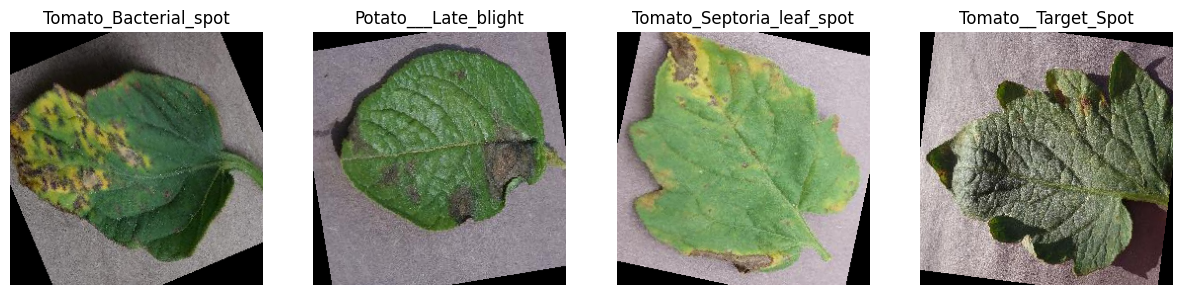

Validate Images:


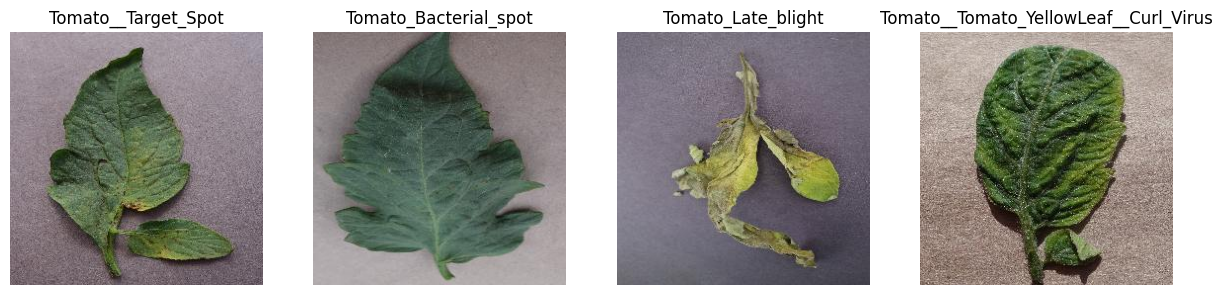

In [7]:
train_images, train_labels = next(iter(train_loader))
validate_images, validate_labels = next(iter(validate_loader))

# Display images
print("Train Images:")
display_images(train_images, [train_dataset.classes[label]for label in train_labels])

print("Validate Images:")
display_images(validate_images, [validate_dataset.classes[label] for label in validate_labels])


# CNN Architecture
This class defines a Convolutional Neural Network (CNN) architecture for image classification. It consists of several convolutional layers, batch normalization layers, ReLU activation functions, max-pooling layers, a global average pooling layer, a fully connected layer, and a dropout layer. The network is designed to process images.                                                                                                                                             

- **Convolutional Layers**: There are four convolutional layers (`conv1` to `conv4`). Each convolutional layer is responsible for extracting features from the input image. As we progress deeper into the network, the number of channels increases (from 32 to 256), allowing the network to learn more complex and abstract features.

- **Batch Normalization**: Each convolutional layer is followed by a batch normalization layer (`bn1` to `bn4`). Batch normalization helps in stabilizing the learning process and reducing the internal covariate shift by normalizing the outputs of each layer.

- **ReLU Activation**: ReLU (Rectified Linear Unit) activation functions (`relu1` to `relu4`) are used after each batch normalization layer. ReLU helps introduce non-linearity into the model, allowing it to learn more complex patterns.

- **Max Pooling**: Max pooling layers (`maxpool1` to `maxpool4`) are used after each ReLU activation. These layers reduce the spatial dimensions of the output from the previous layer, which helps in reducing the number of parameters and computation in the network, and also controls overfitting.

- **Global Average Pooling**: After the last max pooling, a global average pooling layer (`global_avg_pool`) is used. It reduces each feature map to a single number by averaging out the values, which helps in reducing the total number of parameters and makes the model more robust to spatial variations of the input.

- **Fully Connected Layer**: The network includes a fully connected layer (`fc1`) that maps the learned features to the desired number of classes (`num_classes`). This layer is the final classification layer of the network.

- **Dropout**: A dropout layer (`dropout`) with a dropout probability of 0.5 is used before the fully connected layer. Dropout helps in preventing overfitting by randomly dropping units from the neural network during training.

The `forward` method defines the data flow through the network, applying each of these layers and functions in sequence to the input tensor `x`.


In [8]:
class PlantCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(PlantCNN, self).__init__()

        # Convolution 1
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Convolution 3
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        # Convolution 4
        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected 1 (Classifier)
        self.fc1 = nn.Linear(256, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Convolution 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Convolution 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # Convolution 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output

        # Fully connected layer
        x = self.dropout(x)
        x = self.fc1(x)

        return x


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())


True


In [11]:
model=PlantCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [12]:
import matplotlib.pyplot as plt

# Training and Validation Process

## Overview
The model is trained over 20 epochs with an early stopping mechanism. The training process involves updating the model's weights based on the training data, while the validation process evaluates the model's performance on unseen data.

## Key Components
- **Epochs**: The model undergoes 20 training cycles (epochs).
- **Loss Tracking**: `train_losses` and `val_losses` arrays track the training and validation loss for each epoch.
- **Accuracy Tracking**: `val_accuracies` tracks the validation accuracy after each epoch.
- **Early Stopping Parameters**: The training will stop early if there's no improvement in validation loss for 3 consecutive epochs.

## Training Process
During each epoch:
1. **Training Phase**:
   - The model is set to training mode.
   - For each batch of training data:
     - The model makes predictions and calculates the loss.
     - Backpropagation is performed to update the model's weights.

2. **Validation Phase**:
   - The model is set to evaluation mode.
   - For each batch of validation data:
     - The model predicts and calculates the validation loss.
     - The total correct predictions are used to calculate the validation accuracy.

3. **Loss and Accuracy Logging**:
   - Training and validation loss for the epoch are calculated and logged.
   - Validation accuracy is calculated and logged.
   - Progress is printed showing the train loss, validation loss, and validation accuracy for the epoch.

4. **Early Stopping Check**:
   - If the validation loss improves (decreases), update the `best_val_loss`.
   - If there's no improvement, increment the `epochs_no_improve` counter.
   - If `epochs_no_improve` equals the `patience` value (3), early stopping is triggered, and training is halted.

## Output
The output includes epoch-wise train loss, validation loss, and validation accuracy. It also indicates if early stopping was triggered.


In [13]:
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []



patience = 4 
best_val_loss = float('inf')
epochs_no_improve = 0  
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    model.eval()  
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    val_loss = val_running_loss / len(validate_loader.dataset)
    val_acc = 100. * correct / total

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1


    if epochs_no_improve == patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break


Epoch 1/10, Train Loss: 1.6952, Validation Loss: 1.3355, Validation Acc: 57.66%
Epoch 2/10, Train Loss: 1.2413, Validation Loss: 1.1087, Validation Acc: 61.46%
Epoch 3/10, Train Loss: 1.0590, Validation Loss: 1.2875, Validation Acc: 58.83%
Epoch 4/10, Train Loss: 0.9664, Validation Loss: 1.0791, Validation Acc: 62.73%
Epoch 5/10, Train Loss: 0.8973, Validation Loss: 1.5343, Validation Acc: 54.63%
Epoch 6/10, Train Loss: 0.8397, Validation Loss: 1.0577, Validation Acc: 63.80%
Epoch 7/10, Train Loss: 0.7635, Validation Loss: 0.8713, Validation Acc: 67.61%
Epoch 8/10, Train Loss: 0.7449, Validation Loss: 0.5841, Validation Acc: 81.17%
Epoch 9/10, Train Loss: 0.6839, Validation Loss: 0.8064, Validation Acc: 71.41%
Epoch 10/10, Train Loss: 0.6582, Validation Loss: 0.8874, Validation Acc: 72.20%


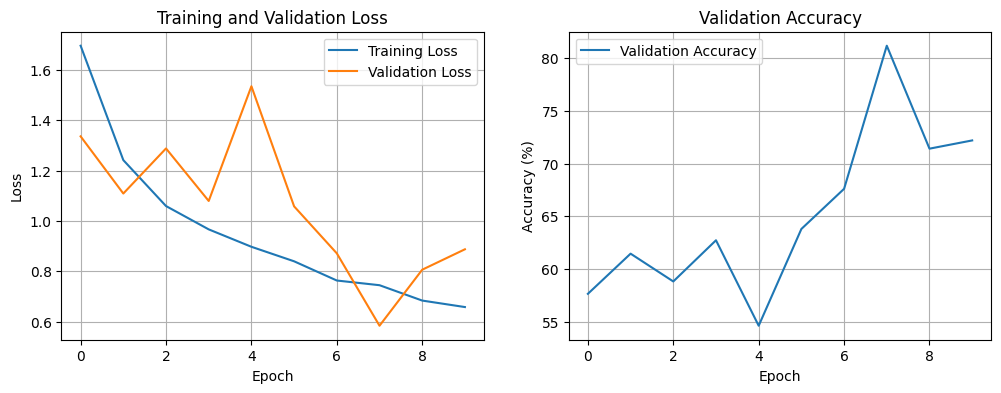

In [14]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.legend()

plt.show()


# Testing the Model

## Overview
Evaluate the model's performance on the test dataset, providing insights into its real-world applicability.

## Process
- **Data Preparation**: Load test data using `ImageFolder` and `DataLoader`.
- **Evaluation Mode**: Set the model to evaluation mode with `model.eval()`.
- **Performance Metrics**: In a loop with `torch.no_grad()`, calculate loss and accuracy by comparing predictions to actual targets. 
- **Results**: Compute average test loss and accuracy, displaying the final performance metrics.

This step is crucial to assess how well the model generalizes to new, unseen data.


In [15]:
from sklearn.metrics import confusion_matrix, precision_score, f1_score


In [16]:
test_dataset = ImageFolder(
    root="Structured_PlantVillageOne/test/", transform=basic_transform)
test_loader = DataLoader(test_dataset, batch_size=32)
model.eval()  
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_target = []

with torch.no_grad():  
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()*data.size(0)

        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_target.extend(target.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100 * correct / total
precision = precision_score(all_target, all_preds, average='macro')
f1 = f1_score(all_target, all_preds, average='macro')

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.4f}, F1 Score: {f1:.4f}")



Test Loss: 0.9953, Test Accuracy: 69.10%
Precision: 0.7594, F1 Score: 0.5842


# Confusion Matrix Visualization

This section visualizes the model's performance using a confusion matrix, an important tool in understanding the classification accuracy in detail.

## Steps:
1. **Compute Confusion Matrix**: Using `confusion_matrix` from `sklearn.metrics` with the actual and predicted labels.
2. **Visualization**: 
   - A heatmap is created using `seaborn` to represent the confusion matrix.
   - The figure size is set to 10x10 for clarity.
   - Labels for predicted (x-axis) and true (y-axis) classes are added for better understanding.

The confusion matrix provides a detailed view of the model's prediction accuracy and misclassifications, offering insights into its strengths and weaknesses in classifying different categories.


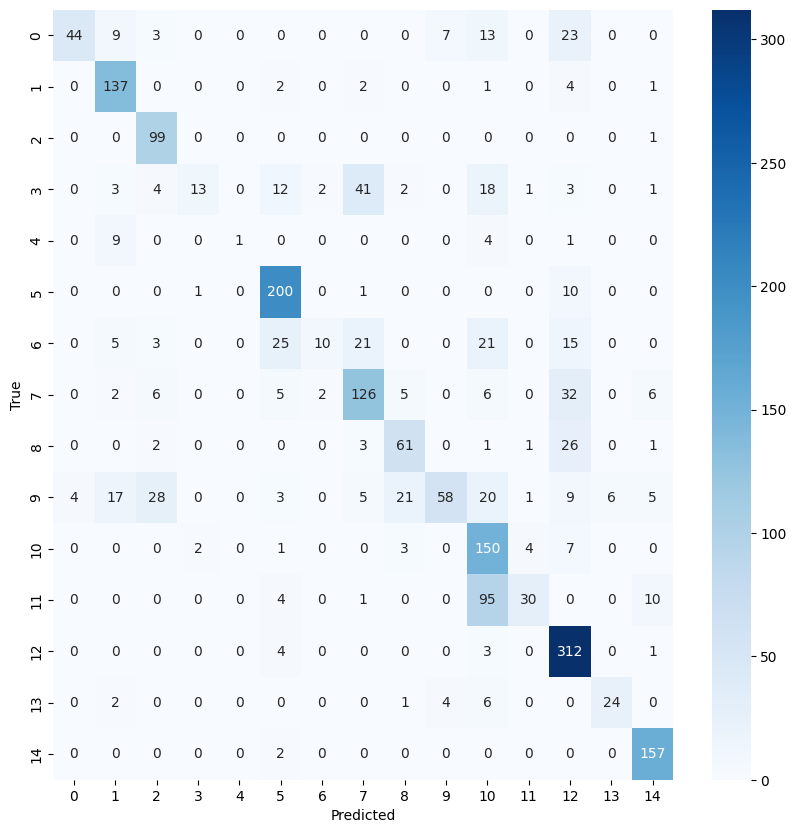

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_target, all_preds)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [18]:
torch.save(model.state_dict(), 'initial_30-11-23-cnn.pt')

In [19]:
model = PlantCNN()
model.load_state_dict(torch.load('initial_30-11-23-cnn.pt'))


<All keys matched successfully>

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

True


# High-Confidence Prediction on Unlabelled Data

## Purpose
This section aims to identify high-confidence predictions from unlabelled data using the trained `ImprovedCNN` model.

## Key Steps
1. **Model Setup**:
   - Load the pre-trained model (`finalcnn.pt`) and set it to evaluation mode.
   - Ensure the model runs on GPU if available, otherwise on CPU.

2. **Data Preparation**:
   - Define a basic transformation (`ToTensor`) for unlabelled data.
   - Load unlabelled data using `ImageFolder` and `DataLoader`.

3. **Identifying High-Confidence Predictions**:
   - Iterate over unlabelled data batches.
   - Calculate softmax probabilities to determine prediction confidences.
   - Select samples where confidence is between 0.85 and 0.95.
   - Store paths and predictions of these high-confidence samples.

4. **Output**:
   - Print the count of high-confidence samples after each batch.
   - Display the final count of high-confidence pseudo-labelled images.

This approach helps in leveraging unlabelled data by focusing on predictions where the model is relatively but not overly confident, aiming to enhance the training dataset with pseudo-labels.


In [21]:
def pseudo_label_images(model, dataset_path, processed_images, lower_confidence_threshold=0.85, upper_confidence_threshold=0.95):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    basic_transform = transforms.ToTensor()
    unlabelled_dataset = ImageFolder(
        root=dataset_path, transform=basic_transform)
    unlabelled_loader = DataLoader(
        unlabelled_dataset, batch_size=32, shuffle=False)

    high_confidence_samples = []
    batch_number = 0

    with torch.no_grad():
        for images, _ in unlabelled_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, predictions = torch.max(probabilities, dim=1)
            for i, (confidence, prediction) in enumerate(zip(confidences, predictions)):
                image_index = batch_number * unlabelled_loader.batch_size + i
                image_path = unlabelled_dataset.imgs[image_index][0]
                if image_path not in processed_images and lower_confidence_threshold < confidence <= upper_confidence_threshold:
                    high_confidence_samples.append(
                        (image_path, prediction.item()))
                    processed_images.add(image_path)

            batch_number += 1
            print(
                f"Batch {batch_number}: Total high-confidence samples so far: {len(high_confidence_samples)}")

    print(
        f"Final number of high-confidence pseudo-labelled images: {len(high_confidence_samples)}")
    return high_confidence_samples, processed_images


In [22]:
high_confidence_samples,processed_images = pseudo_label_images(model,"Structured_PlantVillageOne/unlabelled",set())

Batch 1: Total high-confidence samples so far: 3
Batch 2: Total high-confidence samples so far: 9
Batch 3: Total high-confidence samples so far: 15
Batch 4: Total high-confidence samples so far: 17
Batch 5: Total high-confidence samples so far: 22
Batch 6: Total high-confidence samples so far: 27
Batch 7: Total high-confidence samples so far: 33
Batch 8: Total high-confidence samples so far: 35
Batch 9: Total high-confidence samples so far: 37
Batch 10: Total high-confidence samples so far: 41
Batch 11: Total high-confidence samples so far: 45
Batch 12: Total high-confidence samples so far: 48
Batch 13: Total high-confidence samples so far: 55
Batch 14: Total high-confidence samples so far: 57
Batch 15: Total high-confidence samples so far: 61
Batch 16: Total high-confidence samples so far: 66
Batch 17: Total high-confidence samples so far: 73
Batch 18: Total high-confidence samples so far: 77
Batch 19: Total high-confidence samples so far: 81
Batch 20: Total high-confidence samples so

# Creating a Dataset with Pseudo-Labelled Data

## Purpose
To expand the training dataset by incorporating high-confidence predictions from unlabelled data using a custom dataset class.

## Implementation
1. **Custom Dataset Class**:
   - Define `PseudoLabelledDataset`, a subclass of `torch.utils.data.Dataset`.
   - The class loads images and their pseudo-labels, applying transformations if provided.

2. **Dataset Creation**:
   - Instantiate `PseudoLabelledDataset` with high-confidence samples and the same transformations as the original training dataset.

3. **Combining Datasets**:
   - Merge the original training dataset with the pseudo-labelled dataset using `ConcatDataset`.

4. **DataLoader for Combined Dataset**:
   - Create a DataLoader for the combined dataset, setting a batch size of 32 and enabling shuffling.

This approach augments the training data with pseudo-labelled images, potentially improving the model's learning from a broader data variety.


In [23]:
# Creating a custom dataset for pseudo-labelled data
class PseudoLabelledDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def update_data(self, new_data):
        self.data.extend(new_data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label


# Initialize the pseudo-labelled dataset (empty at the beginning)
pseudo_labelled_dataset = PseudoLabelledDataset([], transform=transform)

# Initialize combined dataset with the original training dataset
combined_dataset = ConcatDataset([train_dataset, pseudo_labelled_dataset])

# Creating initial DataLoader
combined_train_loader = DataLoader(
    combined_dataset, batch_size=32, shuffle=True)

# Function to update datasets for each iteration

def update_datasets_for_iteration(new_pseudo_labels):
    # Update pseudo-labelled dataset
    pseudo_labelled_dataset.update_data(new_pseudo_labels)

    # Update combined dataset
    global combined_dataset
    combined_dataset = ConcatDataset([train_dataset, pseudo_labelled_dataset])

    # Update DataLoader
    return DataLoader(combined_dataset, batch_size=32, shuffle=True)


In [24]:
combined_train_loader=update_datasets_for_iteration(high_confidence_samples)

In [25]:
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10


train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in combined_train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(combined_train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation step
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validate_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / len(validate_loader.dataset)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')


Epoch [1/10], Loss: 0.6044, Validation Loss: 1.2529, Validation Acc: 63.02%
Epoch [2/10], Loss: 0.5565, Validation Loss: 0.6874, Validation Acc: 75.41%
Epoch [3/10], Loss: 0.5360, Validation Loss: 0.6079, Validation Acc: 76.59%
Epoch [4/10], Loss: 0.5174, Validation Loss: 0.9315, Validation Acc: 69.85%
Epoch [5/10], Loss: 0.5121, Validation Loss: 0.7600, Validation Acc: 75.41%
Epoch [6/10], Loss: 0.4954, Validation Loss: 0.6348, Validation Acc: 76.78%
Epoch [7/10], Loss: 0.4769, Validation Loss: 0.7354, Validation Acc: 75.71%
Epoch [8/10], Loss: 0.4800, Validation Loss: 0.4760, Validation Acc: 83.12%
Epoch [9/10], Loss: 0.4505, Validation Loss: 0.6104, Validation Acc: 77.95%
Epoch [10/10], Loss: 0.4413, Validation Loss: 0.5037, Validation Acc: 81.37%


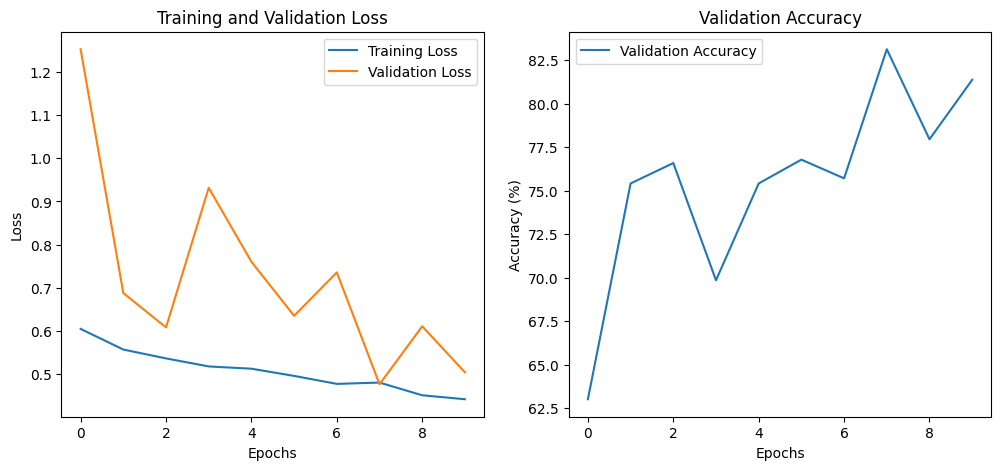

In [26]:
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [27]:
test_dataset = ImageFolder(
    root="Structured_PlantVillageOne/test/", transform=basic_transform)
test_loader = DataLoader(test_dataset, batch_size=32)
model.eval()  
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_target = []

with torch.no_grad():  
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()*data.size(0)

        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_target.extend(target.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100 * correct / total
precision = precision_score(all_target, all_preds, average='macro')
f1 = f1_score(all_target, all_preds, average='macro')

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.4f}, F1 Score: {f1:.4f}")


Test Loss: 0.5810, Test Accuracy: 80.86%
Precision: 0.8118, F1 Score: 0.7592


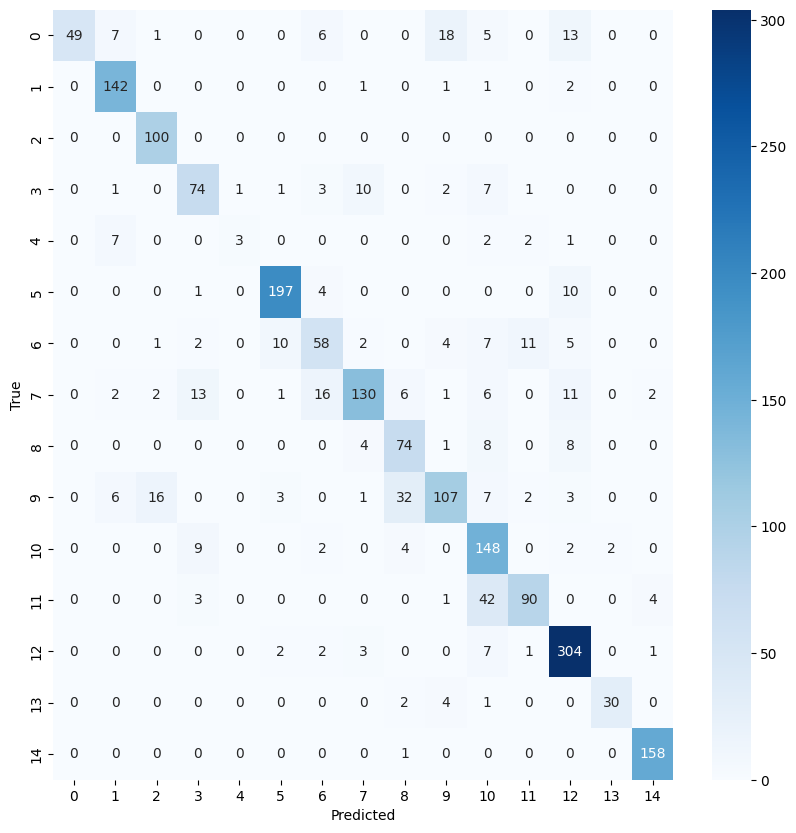

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_target, all_preds)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [29]:
torch.save(model.state_dict(), 'initial_itteration_30-11-2023.pt')


In [30]:
import torch


def train_model(model, criterion, optimizer, train_loader, validate_loader, num_epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)


        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in validate_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(validate_loader.dataset)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')

    return train_losses, val_losses, val_accuracies,model




In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10


Iteration 1:
Batch 1: Total high-confidence samples so far: 8
Batch 2: Total high-confidence samples so far: 14
Batch 3: Total high-confidence samples so far: 21
Batch 4: Total high-confidence samples so far: 25
Batch 5: Total high-confidence samples so far: 30
Batch 6: Total high-confidence samples so far: 39
Batch 7: Total high-confidence samples so far: 44
Batch 8: Total high-confidence samples so far: 47
Batch 9: Total high-confidence samples so far: 51
Batch 10: Total high-confidence samples so far: 58
Batch 11: Total high-confidence samples so far: 65
Batch 12: Total high-confidence samples so far: 73
Batch 13: Total high-confidence samples so far: 75
Batch 14: Total high-confidence samples so far: 79
Batch 15: Total high-confidence samples so far: 83
Batch 16: Total high-confidence samples so far: 88
Batch 17: Total high-confidence samples so far: 93
Batch 18: Total high-confidence samples so far: 100
Batch 19: Total high-confidence samples so far: 107
Batch 20: Total high-confi

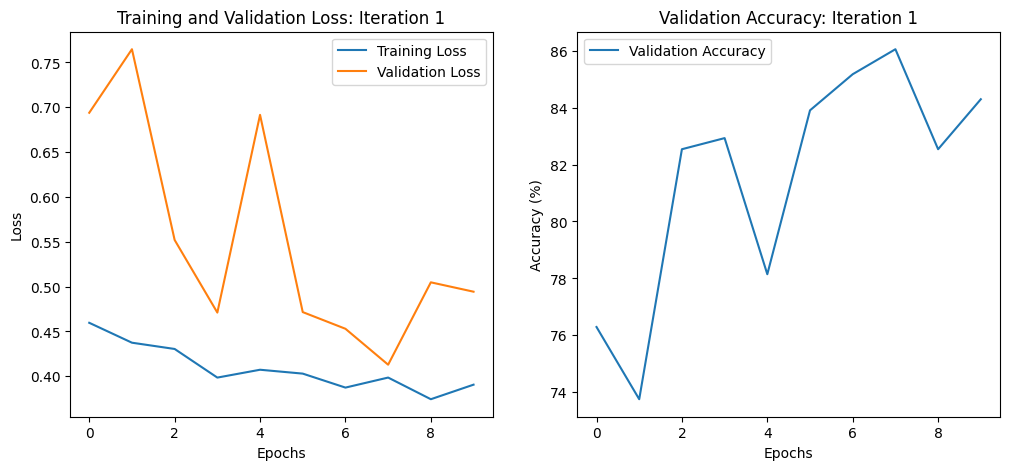

Test Loss: 0.5687, Test Accuracy: 81.68%
Precision: 0.8552, F1 Score: 0.7767


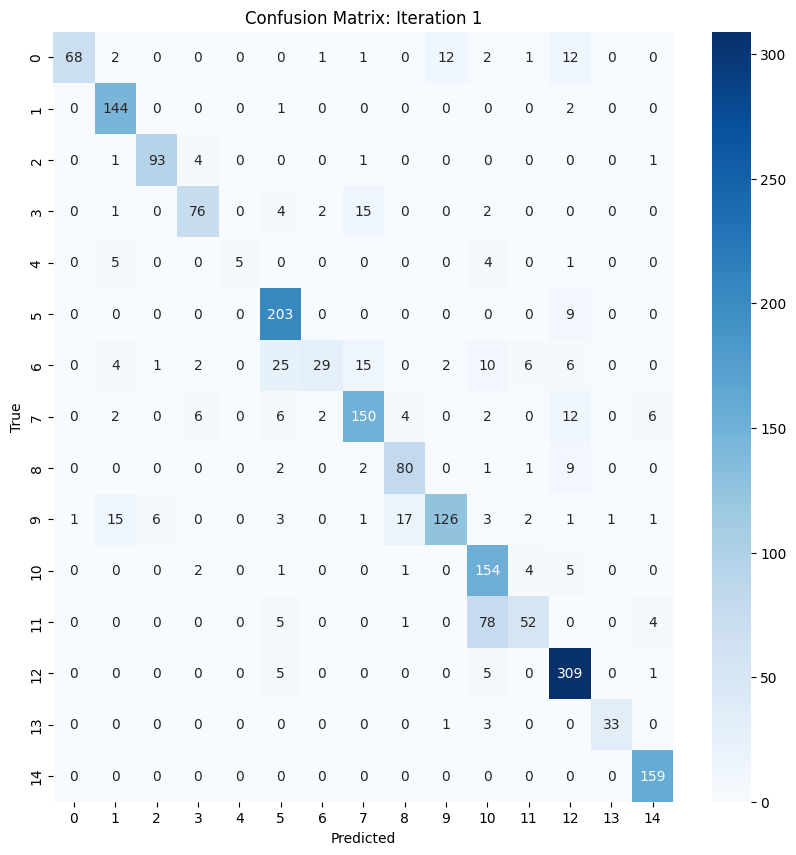

Iteration 2:
Batch 1: Total high-confidence samples so far: 5
Batch 2: Total high-confidence samples so far: 9
Batch 3: Total high-confidence samples so far: 12
Batch 4: Total high-confidence samples so far: 15
Batch 5: Total high-confidence samples so far: 19
Batch 6: Total high-confidence samples so far: 24
Batch 7: Total high-confidence samples so far: 31
Batch 8: Total high-confidence samples so far: 36
Batch 9: Total high-confidence samples so far: 41
Batch 10: Total high-confidence samples so far: 42
Batch 11: Total high-confidence samples so far: 46
Batch 12: Total high-confidence samples so far: 49
Batch 13: Total high-confidence samples so far: 55
Batch 14: Total high-confidence samples so far: 64
Batch 15: Total high-confidence samples so far: 67
Batch 16: Total high-confidence samples so far: 70
Batch 17: Total high-confidence samples so far: 76
Batch 18: Total high-confidence samples so far: 82
Batch 19: Total high-confidence samples so far: 85
Batch 20: Total high-confiden

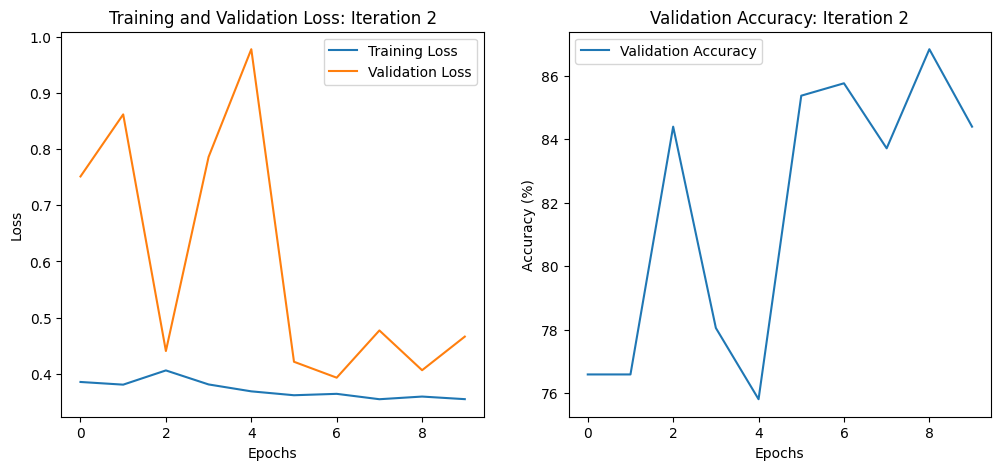

Test Loss: 0.4970, Test Accuracy: 83.62%
Precision: 0.8659, F1 Score: 0.7935


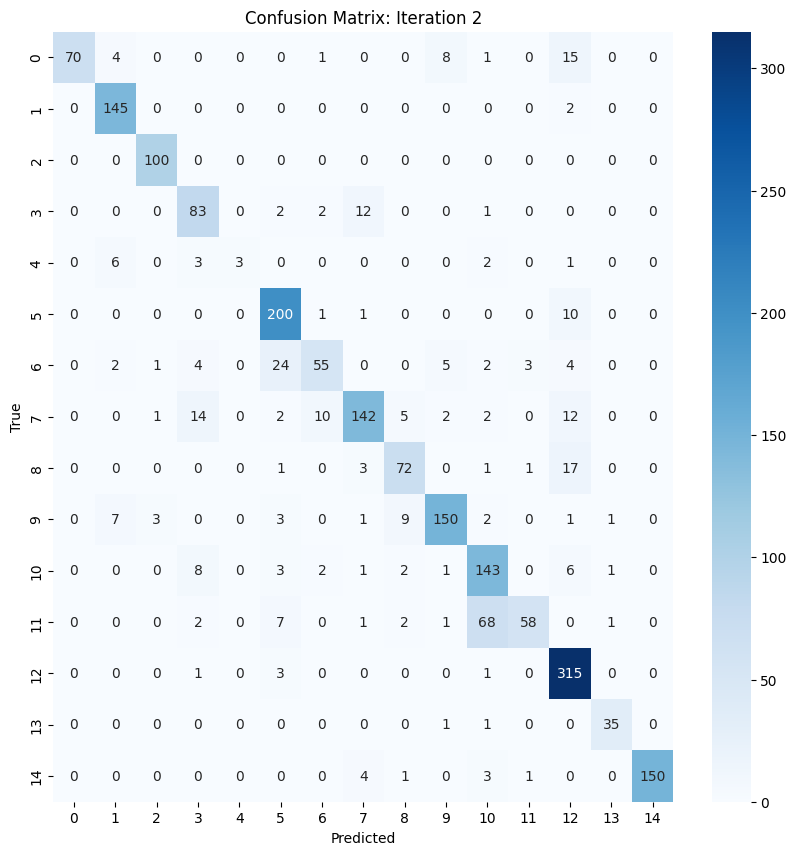

Iteration 3:
Batch 1: Total high-confidence samples so far: 6
Batch 2: Total high-confidence samples so far: 12
Batch 3: Total high-confidence samples so far: 15
Batch 4: Total high-confidence samples so far: 20
Batch 5: Total high-confidence samples so far: 23
Batch 6: Total high-confidence samples so far: 26
Batch 7: Total high-confidence samples so far: 28
Batch 8: Total high-confidence samples so far: 31
Batch 9: Total high-confidence samples so far: 34
Batch 10: Total high-confidence samples so far: 38
Batch 11: Total high-confidence samples so far: 39
Batch 12: Total high-confidence samples so far: 45
Batch 13: Total high-confidence samples so far: 52
Batch 14: Total high-confidence samples so far: 53
Batch 15: Total high-confidence samples so far: 56
Batch 16: Total high-confidence samples so far: 60
Batch 17: Total high-confidence samples so far: 62
Batch 18: Total high-confidence samples so far: 70
Batch 19: Total high-confidence samples so far: 74
Batch 20: Total high-confide

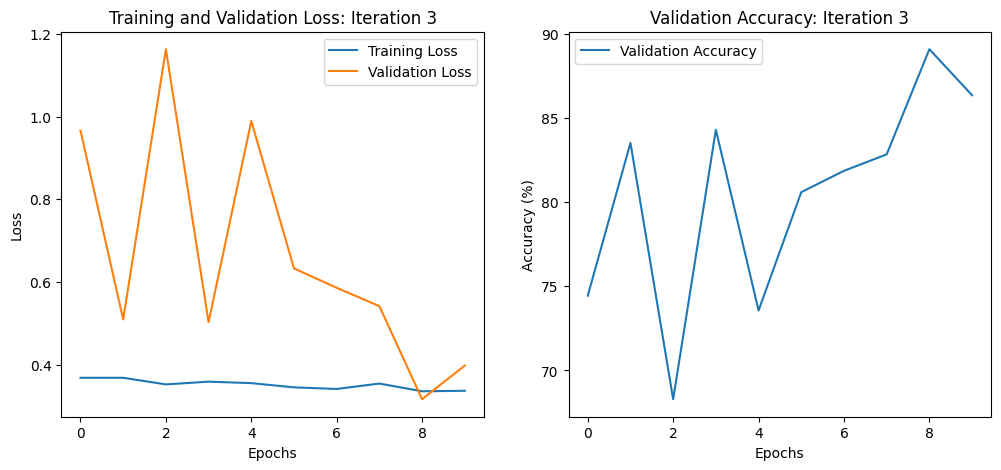

Test Loss: 0.4764, Test Accuracy: 84.65%
Precision: 0.8631, F1 Score: 0.7941


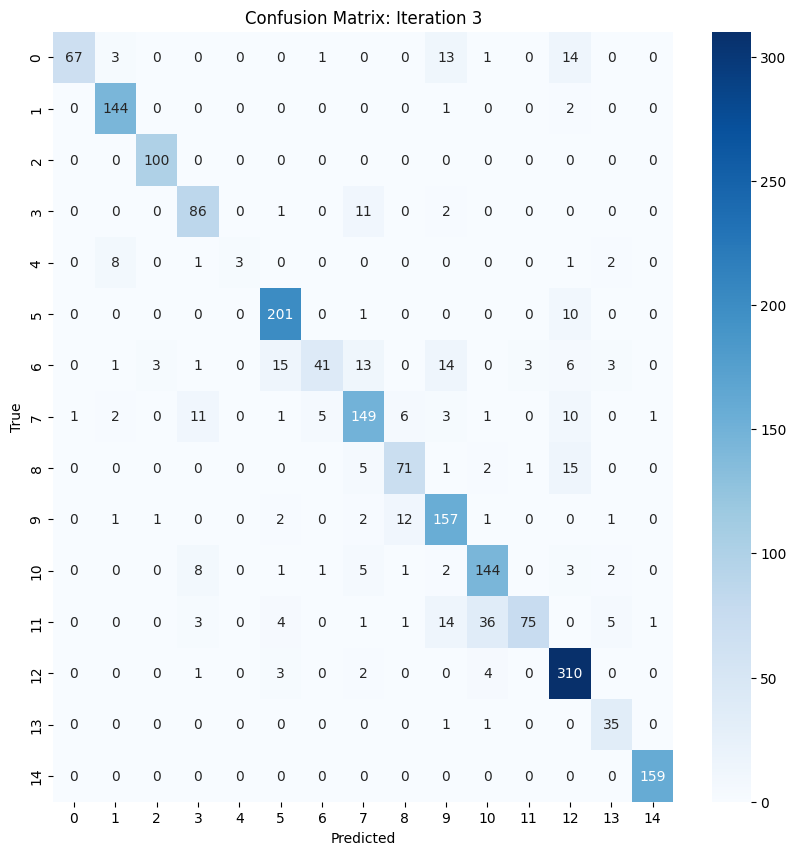

Iteration 4:
Batch 1: Total high-confidence samples so far: 3
Batch 2: Total high-confidence samples so far: 6
Batch 3: Total high-confidence samples so far: 8
Batch 4: Total high-confidence samples so far: 12
Batch 5: Total high-confidence samples so far: 14
Batch 6: Total high-confidence samples so far: 18
Batch 7: Total high-confidence samples so far: 20
Batch 8: Total high-confidence samples so far: 22
Batch 9: Total high-confidence samples so far: 25
Batch 10: Total high-confidence samples so far: 30
Batch 11: Total high-confidence samples so far: 31
Batch 12: Total high-confidence samples so far: 35
Batch 13: Total high-confidence samples so far: 39
Batch 14: Total high-confidence samples so far: 40
Batch 15: Total high-confidence samples so far: 42
Batch 16: Total high-confidence samples so far: 45
Batch 17: Total high-confidence samples so far: 49
Batch 18: Total high-confidence samples so far: 51
Batch 19: Total high-confidence samples so far: 57
Batch 20: Total high-confidenc

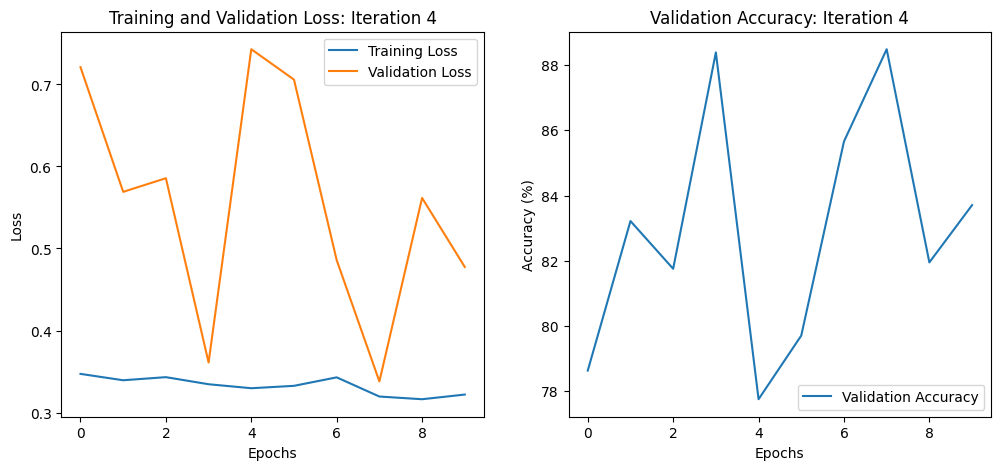

Test Loss: 0.6032, Test Accuracy: 80.56%
Precision: 0.8473, F1 Score: 0.7615


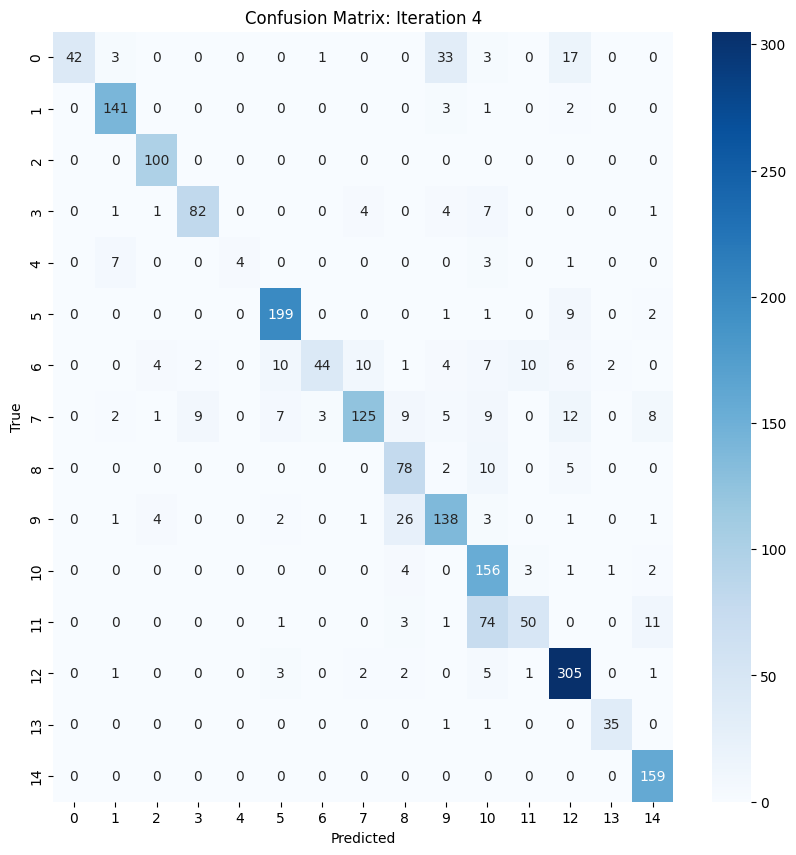

Iteration 5:
Batch 1: Total high-confidence samples so far: 1
Batch 2: Total high-confidence samples so far: 2
Batch 3: Total high-confidence samples so far: 3
Batch 4: Total high-confidence samples so far: 5
Batch 5: Total high-confidence samples so far: 10
Batch 6: Total high-confidence samples so far: 13
Batch 7: Total high-confidence samples so far: 14
Batch 8: Total high-confidence samples so far: 17
Batch 9: Total high-confidence samples so far: 22
Batch 10: Total high-confidence samples so far: 24
Batch 11: Total high-confidence samples so far: 25
Batch 12: Total high-confidence samples so far: 27
Batch 13: Total high-confidence samples so far: 28
Batch 14: Total high-confidence samples so far: 29
Batch 15: Total high-confidence samples so far: 32
Batch 16: Total high-confidence samples so far: 33
Batch 17: Total high-confidence samples so far: 35
Batch 18: Total high-confidence samples so far: 36
Batch 19: Total high-confidence samples so far: 37
Batch 20: Total high-confidence

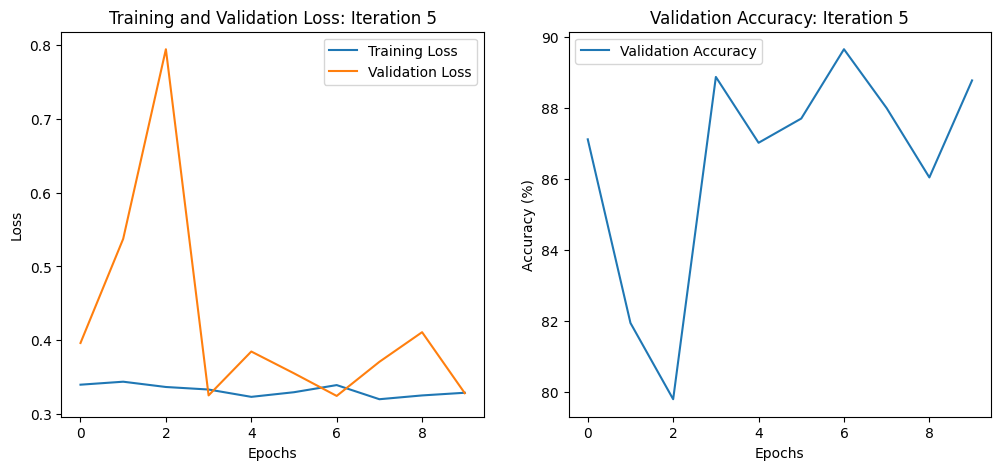

Test Loss: 0.4071, Test Accuracy: 86.64%
Precision: 0.8833, F1 Score: 0.8103


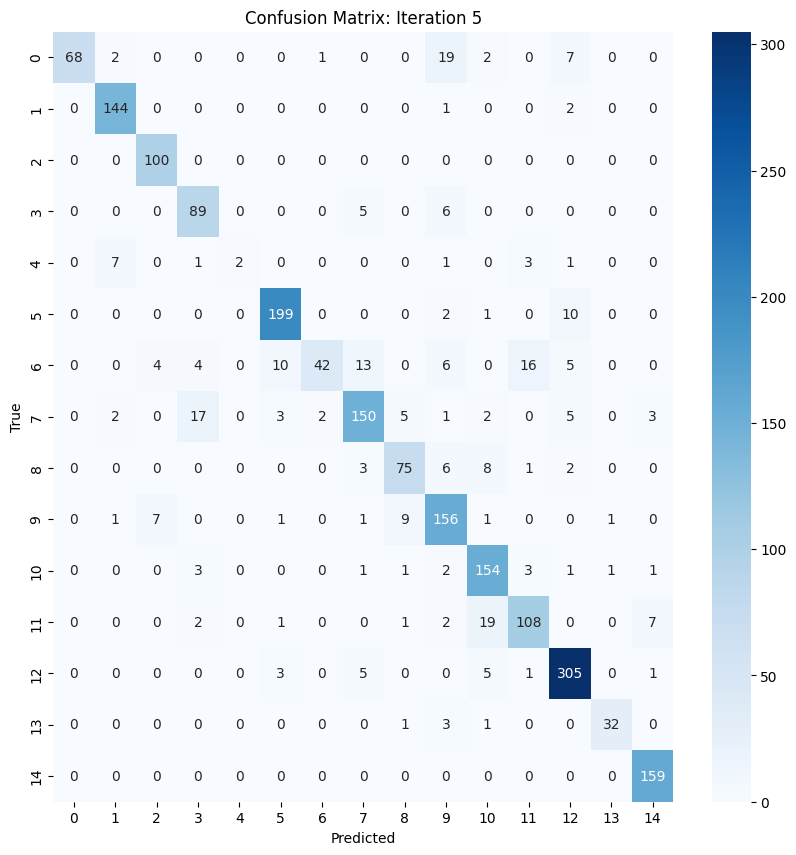

In [32]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, f1_score

# Initialization of the test dataset and loader
test_dataset = ImageFolder(
    root="Structured_PlantVillageOne/test/", transform=basic_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

for iteration in range(5):
    print(f"Iteration {iteration + 1}:")

    # Pseudo-label images
    high_confidence_samples, processed_images = pseudo_label_images(
        model, "Structured_PlantVillageOne/unlabelled", processed_images
    )

    # Update datasets and DataLoader
    combined_train_loader = update_datasets_for_iteration(
        high_confidence_samples)

    # Train the model
    train_losses, val_losses, val_accuracies, model = train_model(
        model=model,
        criterion=torch.nn.CrossEntropyLoss(),
        optimizer=optimizer,
        train_loader=combined_train_loader,
        validate_loader=validate_loader,
        num_epochs=num_epochs,
        device=device
    )

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss: Iteration {iteration + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Validation Accuracy: Iteration {iteration + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

    # Evaluate on test dataset
    model.eval() 
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_target = []

    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = torch.nn.CrossEntropyLoss()(outputs, target)
            test_loss += loss.item()*data.size(0)

            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_target.extend(target.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    precision = precision_score(all_target, all_preds, average='macro')
    f1 = f1_score(all_target, all_preds, average='macro')

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, F1 Score: {f1:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(all_target, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f'Confusion Matrix: Iteration {iteration + 1}')
    plt.show()

